In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gtsa

from pathlib import Path
import psutil
import xarray as xr
import rasterio
import geopandas as gpd
import pandas as pd
import numpy as np
from sklearn import linear_model
import hvplot.xarray

# Time series computations

Demonstrates memory-efficient per-pixel computations along the time axis.

#### Prerequesites
- Download DEM data with `00_download_dem_data.py` or `00_download_dem_data.ipynb`
- Prepare zarr stack with `01_create_stacks.py` or `01_create_stacks.ipynb`

## Start dask cluster

In [3]:
workers = psutil.cpu_count(logical=True)-1
client = gtsa.io.dask_start_cluster(workers,
                                    ip_addres=None, # replace with address if working on remote machine
                                    port=':8787',
                                   )


Dask dashboard at: http://127.0.0.1:8787/status
Workers: 9
Threads per worker: 1 



## Read zarr stack

In [4]:
data_dir = '../../data/dems/south-cascade/' # small test dataset
# data_dir = '../../data/dems/mount-baker' # large dataset

In [5]:
zarr_fn = Path(data_dir, 'stack/stack.zarr').as_posix()
ds = xr.open_dataset(zarr_fn,chunks='auto',engine='zarr')

# optimize chunks and reload lazily
tc,yc,xc = gtsa.io.determine_optimal_chuck_size(ds,print_info = True) 
ds = xr.open_dataset(zarr_fn,chunks={'time': tc, 'y': yc, 'x':xc},engine='zarr')

# assign crs back
crs = rasterio.crs.CRS.from_epsg(32610)
ds = ds.rio.write_crs(crs)


Determining optimal chunk size for processing
Chunk shape: (19,190,138)
Chunk size: 1992720 (1.99272 G)


In [6]:
## optionally select a small window at the center of array for testing purposes
ds = gtsa.geospatial.extract_dataset_center_window(ds, size = 500)

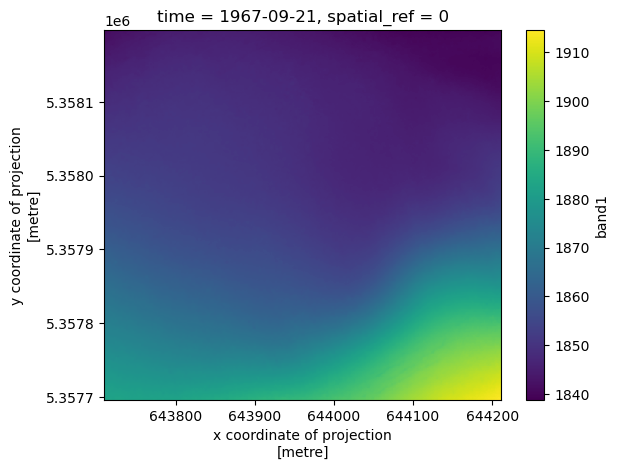

In [7]:
ds['band1'].isel(time=0).plot()

In [8]:
ds['band1'] # each is dimensioned along the full time series

<xarray.DataArray 'band1' (time: 19, y: 500, x: 501)>
dask.array<getitem, shape=(19, 500, 501), dtype=float32, chunksize=(19, 190, 138), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 1967-09-21 1970-09-29 ... 2015-10-14
  * x            (x) float64 6.437e+05 6.437e+05 ... 6.442e+05 6.442e+05
  * y            (y) float64 5.358e+06 5.358e+06 ... 5.358e+06 5.358e+06
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    grid_mapping:   spatial_ref

## Simple computations along time axis

### Count
Compute per-pixel count using built in xarray method

In [9]:
%%time
count = ds['band1'].count(axis=0).compute()

CPU times: user 174 ms, sys: 24.1 ms, total: 198 ms
Wall time: 701 ms


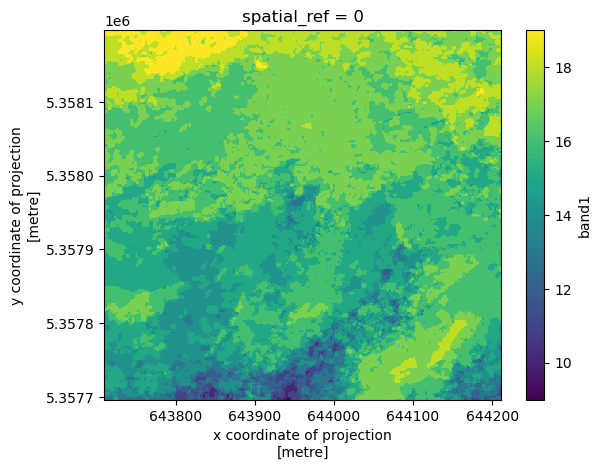

In [10]:
count.plot();

### NMAD
Compute per-pixel Normalized Median Absolute Deviation 

- This example highlights the use of a custom function

In [11]:
def nmad(array):
    if np.all(~np.isfinite(array)):
        return np.nan
    else:
        return 1.4826 * np.nanmedian(np.abs(array - np.nanmedian(array)))

In [12]:
result = xr.apply_ufunc(nmad, 
                        ds['band1'],
                        input_core_dims=[['time']],
                        vectorize=True, 
                        dask='parallelized',
                        output_dtypes=[float],
                       )

In [13]:
%%time
array = result.compute()

CPU times: user 167 ms, sys: 53 ms, total: 220 ms
Wall time: 2.16 s


In [14]:
# create empty DataArray container
nmad_da = ds['band1'].isel(time=0).drop('time') 

# replace data values
nmad_da.values = array 

# give the data variable a name
nmad_da.name   = 'nmad' 

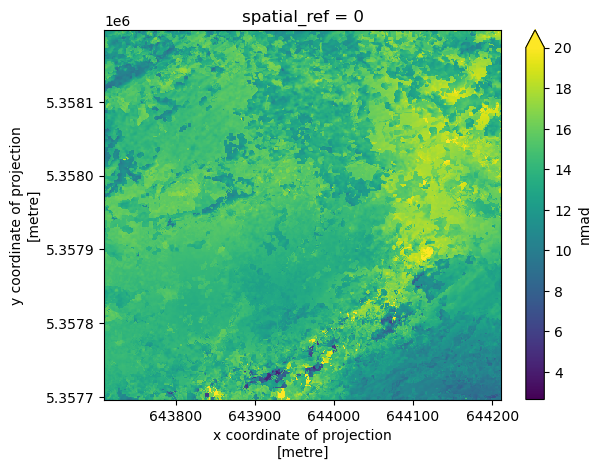

In [15]:
nmad_da.plot(vmax=20);

## Linear regression

In [16]:
# create a time series to make predictions on as decimal year floats
start = ds['time'].dt.strftime('%Y-%m-%d').values[0]
end = ds['time'].dt.strftime('%Y-%m-%d').values[-1]
prediction_time_series = gtsa.temporal.create_prediction_timeseries(start_date = start,
                                                                    end_date = end,
                                                                    dt ='Y')

# prepare time values as decimal year floats
times = [pd.to_datetime(j) for j in ds['band1'].time.values]
decyear_times = [gtsa.utils.date_time_to_decyear(i) for i in times] 
decyear_times = np.array(decyear_times)

ds['time'] = decyear_times

#### Example 1
Compute linear regression using a custom function with condition

In [17]:
def custom_linreg(x,y, threshold = 2):
    mask = np.isfinite(y) # create mask for np.nan values
    if len(y[mask]) < threshold: # return np.nan if less than threshold
        return np.nan
    return np.polyfit(x[mask], y[mask], 1)[0]

In [18]:
result = xr.apply_ufunc(
        custom_linreg, decyear_times , ds['band1'],
        input_core_dims=[['time'], ['time']],
        vectorize=True, 
        dask='parallelized',
        output_dtypes=[float],
        )

In [19]:
custom_slope = result.compute()

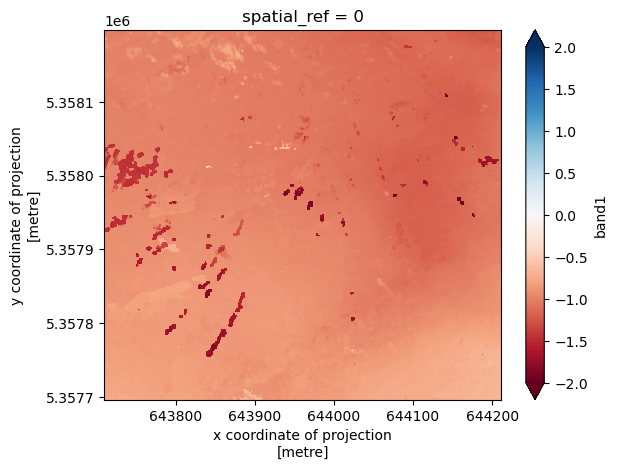

In [20]:
custom_slope.plot(vmin =-2, vmax = 2, cmap ='RdBu')

#### Example 2
Compute linear regression using built-in xarray polyfit function
- throws warnings when only a single data point is present in the time series

In [21]:
result = ds['band1'].polyfit(dim='time', deg = 1).compute()

In [22]:
slope = result['polyfit_coefficients'].sel(degree = 1)

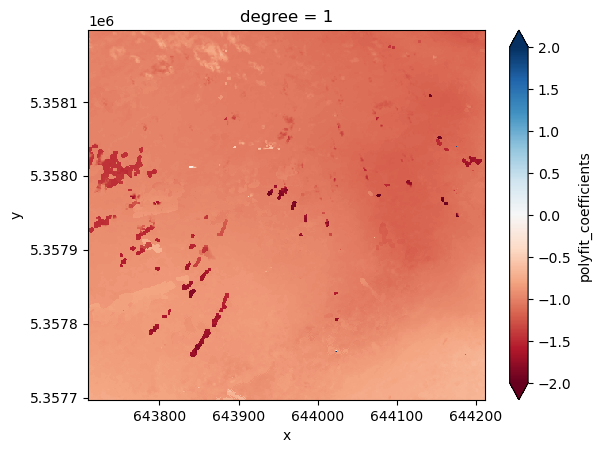

In [23]:
slope.plot(vmin =-2, vmax = 2, cmap ='RdBu')

#### Example 3

Compute linear regression using [Theil-Sen regressor](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.TheilSenRegressor.html)

- Using numpy for a linear regression is much faster than the external Theil-Sen function
- The Theil-Sen regression is more robust to outliers than a standard fit

In [24]:
def ts_linreg(x,y, threshold = 2):
    mask = np.isfinite(y)
    if len(y[mask]) < threshold: 
        return np.nan 
    m = linear_model.TheilSenRegressor()
    return m.fit(x[mask][:, np.newaxis], y[mask]).coef_ # return slope

In [25]:
result = xr.apply_ufunc(
        ts_linreg, decyear_times , ds['band1'],
        input_core_dims=[['time'], ['time']],
        vectorize=True, 
        dask='parallelized',
        output_dtypes=[float],
        )

In [26]:
ts_slope = result.compute()

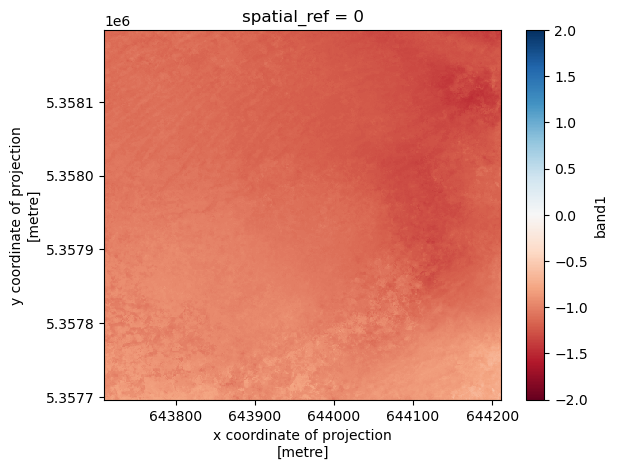

In [27]:
ts_slope.plot(vmin =-2, vmax = 2, cmap ='RdBu')

## Fitting polynomials

In [28]:
degree = 5
result = ds['band1'].polyfit(dim='time', deg = degree).compute()

In [29]:
data = np.array(prediction_time_series)
coords = [np.array(prediction_time_series)]
dims = ['time']

In [30]:
prediction_da = xr.DataArray(data,
                             coords,
                             dims = dims)
prediction_da.name = 'time'

In [31]:
estimate = xr.polyval(prediction_da['time'], 
                      result.polyfit_coefficients)

estimate.name = 'elevation' 

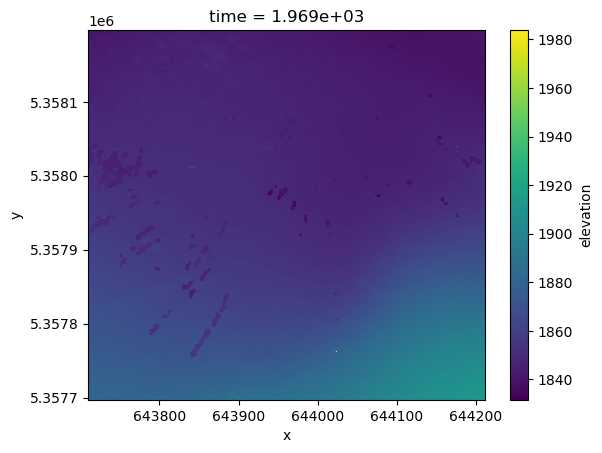

In [32]:
estimate.isel(time=1).plot()

In [ ]:
estimate.hvplot(groupby='time', 
                width=800,
                height=500,
                widget_type='scrubber', 
                widget_location='bottom', 
                clim=(1800,1900),
                cmap='viridis')

## Gaussian Process Regression

In [34]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import (
    RBF,
    ConstantKernel,
    ExpSineSquared,
    PairwiseKernel,
    RationalQuadratic,
    WhiteKernel,
    Matern,
)

In [35]:
k1 = 30.0 * Matern(length_scale=10.0, nu=1.5)
k2 = ConstantKernel(30) * ExpSineSquared(length_scale=1, periodicity=30)
k3 = ConstantKernel(30) * ExpSineSquared(length_scale=1, periodicity=1)

kernel = k1+k2+k3

In [36]:
ds_result = gtsa.temporal.dask_apply_GPR(ds['band1'],
                                         'time', 
                                         kwargs={'times':ds['band1'].time.values,
                                                 'kernel': kernel,
                                                 'prediction_time_series' : prediction_time_series}
                                        ).compute()

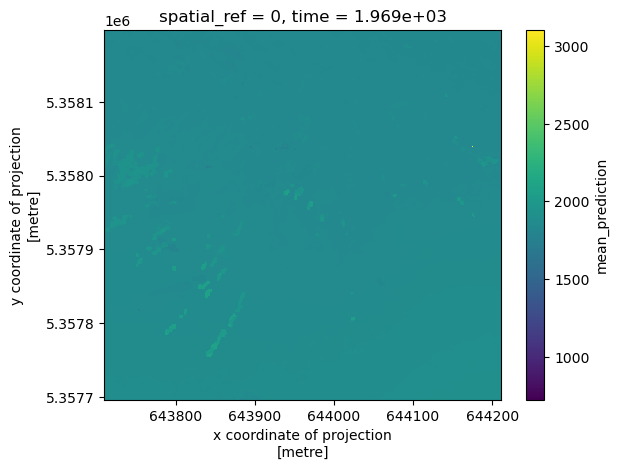

In [38]:
ds_result['mean_prediction'].isel(time=1).plot();

In [39]:
ds_result['mean_prediction'].hvplot(groupby='time', 
                                    width=800,
                                    height=500,
                                    widget_type='scrubber', 
                                    widget_location='bottom', 
                                    clim=(1800,1900),
                                    cmap='viridis')

Column
    [0] HoloViews(DynamicMap, height=500, sizing_mode='fixed', widget_location='bottom', widget_type='scrubber', width=800)
    [1] WidgetBox(align=('center', 'end'))
        [0] Player(end=47, width=550)